In [2]:
import re
import os
import sys
import numpy as np
import pandas as pd
from PIL import Image
import scipy.io
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import datetime

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"]=""

# Lade der Daten

In [7]:
# Laden der vorverarbeiteten Daten von Choy et al.
def construct_file_path_list_from_dir(dir, file_filter):
    if isinstance(file_filter, str):
        file_filter = [file_filter]
    paths = [[] for _ in range(len(file_filter))]

    for root, _, files in os.walk(dir):
        for f_name in files:
            for i, f_substr in enumerate(file_filter):
                if f_substr in f_name:
                    (paths[i]).append(root + '/' + f_name)

    for i, p in enumerate(paths):
        paths[i] = natsorted(p)

    if len(file_filter) == 1:
        return paths[0]

    return tuple(paths)

def load_preprocessed_dataset():
    data_preprocessed_dir = "data_preprocessed"
    
    data_all = sorted(construct_file_path_list_from_dir(data_preprocessed_dir, ["_x.npy"]))
    
    label_all = sorted(construct_file_path_list_from_dir(data_preprocessed_dir, ["_y.npy"]))
    
    return np.array(data_all), np.array(label_all)

In [10]:
data, label = load_preprocessed_dataset()
print(data)

['data_preprocessed/02691156_121b5c1c81aa77906b153e6e0582b3ac_x.npy'
 'data_preprocessed/02691156_124062ccaeae95085e9e2656aff7dd5b_x.npy'
 'data_preprocessed/02691156_13370c42b8ea45cf5e8172e6d9ae84ff_x.npy'
 'data_preprocessed/02691156_13f9eb29d699488a99eab31c7df6f5c3_x.npy'
 'data_preprocessed/02691156_152d35bcceab5592eb1a0518c224975f_x.npy'
 'data_preprocessed/02691156_1d4f988b009edadf54a2210c7b2aa25_x.npy'
 'data_preprocessed/02691156_1e9acb74ad09ba97192ddbe75f0b85fe_x.npy'
 'data_preprocessed/02691156_1fc2625479e798b11944f01d3ab2091b_x.npy'
 'data_preprocessed/02691156_1fccf0064e0aebfeb179f2ac46747670_x.npy'
 'data_preprocessed/02691156_261093138afff514d8d7812d176664b2_x.npy'
 'data_preprocessed/02691156_265f5348ab2320b2148672750a1a335_x.npy'
 'data_preprocessed/02691156_2b0a2bb1556c96b94f762cd8ae1b1c4b_x.npy'
 'data_preprocessed/02691156_32d9fe9366da899b90b73cf2bf8fe3d1_x.npy'
 'data_preprocessed/02691156_33faf711ed54a4d3db22b838c125a50b_x.npy'
 'data_preprocessed/02691156_34d467f

In [ ]:
def train_val_test_split(data, label, split=0.1):
    # Split der Daten in Trainings und Testdaten
    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        data, label, test_size=split)  # shuffled
    # Weiteres Splitten der Trainingsdaten in Validationdaten
    X_train, X_val, y_train, y_val = model_selection.train_test_split(
        X_train, y_train, test_size=split)  # shuffled

    return X_train, y_train, X_val, y_val, X_test, y_test

# Geteilstes Dataset (immer noch in URLs)
X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(data, label)

# Laden der Daten in Batches - Custom Generator

In [12]:
# Hilfsfunktion, um Numpy-Daten in den 
def load_npy(npy_path):
    ret = []
    for p in npy_path:
        ret.append(np.load(p))
    return np.stack(ret)

In [13]:
class Batch_Load_Generator(keras.utils.Sequence) :

    def __init__(self, X, y, batch_size) :
        self.X = X
        self.y = y
        self.batch_size = batch_size


    def __len__(self) :
        return (np.ceil(len(self.X) * 24 / float(self.batch_size * 24))).astype(np.int)

    # Laden der Trainingsdaten aus den Numpy-Dateien in Batches
    def __getitem__(self, idx) :
        batch_x = self.X[idx * self.batch_size : (idx+1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size : (idx+1) * self.batch_size]
        
        
        output_X = []
        output_y = []
        img_batch_X = load_npy(batch_x)
        for index ,imgs in enumerate(img_batch_X):
            for img in imgs:
                img = img[:, :, 0:3]
                output_X.append(img)
                
                vox = np.load(batch_y[index])
                vox = np.argmax(vox, axis=-1)
                vox = vox.transpose(2, 0, 1)
                output_y.append(vox)
                
        return (np.array(output_X), np.array(output_y))

# Loss Funktion

In [14]:
def voxel_loss_function(y, y_predicted):    
    return tf.nn.softmax_cross_entropy_with_logits(y, y_predicted, axis=3)    

# Metric: Eigene IoU

In [15]:
def intersection_over_union(y, y_predicted):
    y_predicted = tf.where(y_predicted >= 1, 1, 0)
    
    m = tf.keras.metrics.MeanIoU(num_classes=2)
    m.update_state(y, y_predicted)
    
    return m.result()

# Model

In [2]:
# Modell für ein lokales Training, auf dem in der Masterarbeit erwähnten Laptop
encoder = tf.keras.Sequential([
    tf.keras.layers.Conv2D(7, (2, 2), padding="same", input_shape=(137,137,3)),
    tf.keras.layers.Activation(tf.keras.activations.relu),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    tf.keras.layers.Conv2D(1, (2, 2), padding="same"),
    tf.keras.layers.Activation(tf.keras.activations.relu),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(8, (3, 3), strides=2, padding='same'),
    tf.keras.layers.Activation(tf.keras.activations.relu),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
])


decoder = tf.keras.Sequential([
    tf.keras.layers.Reshape((8, 8, 8, 1), input_shape=(8, 8, 8)),
    tf.keras.layers.Conv3DTranspose(8, (3, 3, 3), strides= 2, padding="same"),
    tf.keras.layers.Activation(tf.keras.activations.relu),
    
    tf.keras.layers.Conv3DTranspose(16, (3, 3, 3), strides= 2, padding="same"),
    tf.keras.layers.Activation(tf.keras.activations.relu),
    
    tf.keras.layers.Conv3DTranspose(1, (3, 3, 3), activation="sigmoid", padding ="same"),
    tf.keras.layers.Reshape([32,32,32])
])


model = keras.models.Sequential([encoder, decoder])  

In [3]:
# Modell, mit welchem auf dem Server trainiert wurde
encoder = tf.keras.Sequential([
    tf.keras.layers.Conv2D(137, (2, 2), padding="same", input_shape=(137,137,3), kernel_initializer=tf.keras.initializers.HeNormal()),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation(tf.keras.layers.LeakyReLU(alpha=0.2)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=2),

    tf.keras.layers.Conv2D(64, (2, 2), padding="same", kernel_initializer=tf.keras.initializers.HeNormal()),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation(tf.keras.layers.LeakyReLU(alpha=0.2)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(8, (3, 3), strides=2, padding='same', kernel_initializer=tf.keras.initializers.HeNormal()),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation(tf.keras.layers.LeakyReLU(alpha=0.2)),
    
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
])

decoder = tf.keras.Sequential([
    tf.keras.layers.Reshape((8, 8, 8, 1), input_shape=(8, 8, 8)),
    
    
    tf.keras.layers.Conv3DTranspose(16, (3, 3, 3), padding="same", kernel_initializer=tf.keras.initializers.HeNormal()),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation(tf.keras.activations.relu),
    
    tf.keras.layers.Conv3DTranspose(32, (3, 3, 3), strides= 2, padding="same", kernel_initializer=tf.keras.initializers.HeNormal()),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation(tf.keras.activations.relu),
    
    tf.keras.layers.Conv3DTranspose(64, (3, 3, 3), strides= 2, padding="same", kernel_initializer=tf.keras.initializers.HeNormal()),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation(tf.keras.activations.relu),

    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv3DTranspose(1, (3, 3, 3), activation="sigmoid", padding ="same", kernel_initializer=tf.keras.initializers.GlorotNormal()),
    tf.keras.layers.Reshape([32,32,32])
    
])

decoder.summary()

model = keras.models.Sequential([encoder, decoder])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 8, 8, 8, 1)        0         
_________________________________________________________________
conv3d_transpose (Conv3DTran (None, 8, 8, 8, 16)       448       
_________________________________________________________________
batch_normalization_3 (Batch (None, 8, 8, 8, 16)       64        
_________________________________________________________________
activation_3 (Activation)    (None, 8, 8, 8, 16)       0         
_________________________________________________________________
conv3d_transpose_1 (Conv3DTr (None, 16, 16, 16, 32)    13856     
_________________________________________________________________
batch_normalization_4 (Batch (None, 16, 16, 16, 32)    128       
_________________________________________________________________
activation_4 (Activation)    (None, 16, 16, 16, 32)   

In [17]:
training_batch_generator = Batch_Load_Generator(X_train, y_train, 2)
valid_batch_generator = Batch_Load_Generator(X_val, y_val, 2)

In [18]:
opt = keras.optimizers.Adam(learning_rate=0.01)

model.compile(optimizer=opt, loss=voxel_loss_function, metrics=[tf.keras.metrics.Accuracy(), intersection_over_union], run_eagerly=True)

In [ ]:
# Fitten, also trainieren, des Modells. Die Batchsize ist auf Größe 24, da 24 Ansichten der einzelnen Objekte existieren und auch so geladen werden

batch_size = 1 * 24
stepts_per_epoch = int(len(X_train)* 24 // batch_size)
validation_steps = int(len(X_val)* 24 // batch_size)

checkpoint_path = "training/weights.{epoch:02d}-{val_loss:.2f}.hdf5"


cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)



log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(training_batch_generator,
                    epochs=1, validation_data=valid_batch_generator,
                    callbacks=[cp_callback, tensorboard_callback])


# Predicten eines einzelnen Testbilds

In [ ]:
model.load_weights("weights.1500-10.16.hdf5")
img = np.load(X_test[3])[0]
img = img[None, ...]
img = img[:, :, :, 0:3]

predicted = model.predict(img)
predicted = predicted[0]

np.save("rae_model", predicted)
# Treshold Für Voxel Daten
predicted = np.where(predicted >= 1, 1, 0)

In [4]:
# Dieser Block wurde fir die zeitliche Messung des Predictens genutzt
import time
start = time.time()
model.load_weights("weights.1500-7.80.hdf5")

img = np.array(Image.open("experimente/table.png"))
img = img[None, ...]
img = img[:, :, :, 0:3]


predicted = model.predict(img)
end = time.time()
print((end - start)*1000.0)


4923.867464065552


## Predicten mehrerer Testbilder für die Experimente

In [ ]:
model.load_weights("weights.1500-7.80.hdf5")

paths = ["experimente/airplane.png", 
         "experimente/car.png", 
         "experimente/chair.png", 
         "experimente/gießkanne.png", 
         "experimente/komplex_chair.png", 
         "experimente/real_airplane.png", 
         "experimente/real_car.png", 
         "experimente/real_car_bmw.png", 
         "experimente/real_chair.png",
         "experimente/schrank.png", 
         "experimente/schraube.png", 
         "experimente/tasse.png"]

all_imgs = []

for path in paths:
    path = "data/ShapeNetRendering" + path
    img = np.array(Image.open(path))
    all_imgs.append(img)

for ind, img in enumerate(all_imgs):
    img = img[None, ...]
    img = img[:, :, :, 0:3]
    
    predicted = model.predict(img)
    predicted = predicted[0]
    np.save("experimente/model_" + str(ind), predicted)

# Convertierung des Modells in ein TFLite Modell (Mobil)

In [43]:
model.load_weights("weights.1500-7.80.hdf5")
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS,
  tf.lite.OpsSet.SELECT_TF_OPS
]
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Natalie\AppData\Local\Temp\tmp22j864wf\assets


INFO:tensorflow:Assets written to: C:\Users\Natalie\AppData\Local\Temp\tmp22j864wf\assets


# Voxel Visualisierung

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


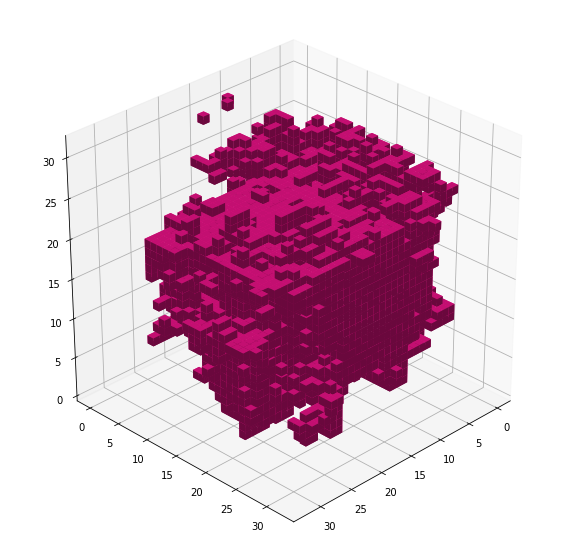

In [9]:
modelimg = "table"
predicted = np.load('experimente/model1/' + modelimg + '.npy')
predicted = np.where(predicted >= 1, 1, 0)

fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')
ax.voxels(predicted, facecolors='deeppink')
ax.view_init(30, 45)
plt.savefig('experimente/model1/' + modelimg + '.png')
fig.show()

# Helper Methods

In [ ]:
# Backslash zu slash, für die Aufbereitung von Numpy-Daten für Windows

#X_train = np.load("preprocessed_data/data/paths/train_imgs.npy")
#y_train = np.load("preprocessed_data/data/paths/train_voxels.npy")
#X_valid = np.load("preprocessed_data/data/paths/val_imgs.npy")
y_valid = np.load("preprocessed_data/data/paths/val_voxels.npy")

file = np.char.replace(y_valid, '\\', '/')
print(file)
np.save("preprocessed_data/data/paths_server/val_voxels.npy",file )